# Sentiment-Based Trading Model Training

This notebook trains a neural network model that incorporates news sentiment as a feature for predicting stock price movements.

## Data collection

In [48]:
import os
import sys
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, StockLatestQuoteRequest
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import time

from trading_bot_llm_sentiment_brian import TradingBotLLMSentiment
from tensorflow.keras.regularizers import l2


In [3]:
load_dotenv()

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Initialize the trading bot to use its data collection methods
bot = TradingBotLLMSentiment()
print(f"Bot initialized with symbols: {bot.symbols}")

# Create data directory if it doesn't exist
os.makedirs('data', exist_ok=True)

2025-04-07 18:08:07,225 - trading_bot_llm_sentiment_brian - INFO - Trading bot trading_bot_llm_sentiment_brian initialized with symbols: ['AAPL', 'MSFT', 'META', 'GOOGL', 'AMZN', 'NVDA']
Bot initialized with symbols: ['AAPL', 'MSFT', 'META', 'GOOGL', 'AMZN', 'NVDA']


In [ ]:
days=365
symbols = ['AAPL', 'MSFT', 'META', 'GOOGL', 'AMZN', 'NVDA']

symbol = 'AAPL'
filename = 'combined_historical_with_daily_sentiment.csv'

In [2]:
api_key = os.environ['ALPACA_API_KEY']
api_secret = os.environ['ALPACA_API_SECRET']
data_client = StockHistoricalDataClient(api_key, api_secret)

In [31]:
df = bot.get_historical_data(symbol, days=days)

2025-03-27 21:29:53,934 - trading_bot_llm_sentiment_brian - INFO - Retrieved 250 bars for AAPL


In [48]:
df.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAPL,2025-03-17 04:00:00+00:00,213.31,215.2200,209.97,214.00,48073426.0,577436.0,213.202242
1,AAPL,2025-03-18 04:00:00+00:00,214.16,215.1500,211.49,212.69,42432426.0,493004.0,213.109470
2,AAPL,2025-03-19 04:00:00+00:00,214.22,218.7600,213.75,215.24,54385391.0,524678.0,215.609629
3,AAPL,2025-03-20 04:00:00+00:00,213.99,217.4899,212.22,214.10,48862947.0,499769.0,214.396693
4,AAPL,2025-03-21 04:00:00+00:00,211.56,218.8400,211.28,218.27,94127768.0,496948.0,215.734078


In [5]:
def collect_historical_data_with_daily_sentiment(symbol, days=365):
    """
    Collect historical price data and daily sentiment data for a given symbol.
    
    Args:
        symbol (str): Stock symbol.
        days (int): Number of days of historical data to collect.
        
    Returns:
        DataFrame: Combined price and sentiment data.
    """
    print(f"Collecting data for {symbol}...")
    
    # Get historical price data
    df = bot.get_historical_data(symbol, days=days)
    if df is None:
        print(f"No historical data found for {symbol}")
        return None
    
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Extract the date from the timestamp for daily grouping
    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    daily_dates = df['date'].unique().tolist()
    
    print(f"Collected {len(df)} price data points, calculating sentiment for {len(daily_dates)} days...")
    
    # Add sentiment column
    df['sentiment'] = np.nan
    
    # Get sentiment for each day
    for date in daily_dates:
        date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
        print(f"Getting sentiment for {symbol} for {date_str}")
        
        articles = 10
        news_date = pd.to_datetime(date)
        # Using a 1-day lookback range to fetch daily sentiment
        lookback_range = timedelta(days=1)
        
        sentiment = bot.get_sentiment_signal(symbol, articles, news_date, lookback_range)
        df.loc[df['date'] == date, 'sentiment'] = sentiment
        time.sleep(1)
    
    
    # Drop rows with NaN values
    # df = df.dropna()
    
    print(f"Final dataset: {len(df)} rows for {symbol}")
    return df


## Process all symbols and save the dataset

In [ ]:
# List to store dataframes for each symbol
dfs = []

for symbol in symbols:
    try:
        data = collect_historical_data_with_daily_sentiment(symbol)
        if data is not None:
            # Optionally add a symbol column if you want a combined DF later
            data['symbol'] = symbol  
            
            # Save individual CSV for each symbol
            data.to_csv(f"data/{symbol}_historical_with_daily_sentiment.csv", index=False)
            print(f"Saved data for {symbol}")
            
            # Append to our list for later combining
            dfs.append(data)
        else:
            print(f"No data found for {symbol}")
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

# If you want a single combined DataFrame for all symbols:
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.to_csv("data/combined_historical_with_daily_sentiment.csv", index=False)
    print("Saved combined data for all symbols.")
else:
    print("No data to combine.")


In [36]:
def create_sequences(df, seq_length=SEQ_LENGTH, feature_columns=all_features):
    """
    Create sequences from the DataFrame using a sliding window.
    For each sequence of past `seq_length` days, the target is the closing price on day seq_length+1.
    """
    X, y = [], []
    if len(df) < seq_length + 1:
        return None, None
    for i in range(len(df) - seq_length):
        # Sequence of features for past seq_length days
        seq = df.iloc[i:i+seq_length][feature_columns].values
        # Target is next day's closing price
        target = df.iloc[i+seq_length]['close']
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

## Model Training

In [7]:
SEQ_LENGTH = 30  # use past 30 days
FEATURES = ['open', 'high', 'low', 'close', 'volume', 'sentiment'] 
TRAIN_RATIO = 0.8

# Identify which features to scale (excluding sentiment which is already -1 to 1)
FEATURES_TO_SCALE = ['open', 'high', 'low', 'close', 'volume']


In [8]:
combined_file = "data/combined_historical_with_daily_sentiment.csv"
if not os.path.exists(combined_file):
    raise FileNotFoundError(f"{combined_file} does not exist.")


In [29]:
df = pd.read_csv(combined_file, index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['symbol', 'timestamp'])

In [30]:
df.tail(1)

,timestamp,open,high,low,close,volume,trade_count,vwap,date,sentiment
symbol,,,,,,,,,,
NVDA,2025-03-28 04:00:00+00:00,111.485,112.87,109.0701,109.67,229872549.0,1847538.0,110.119953,2025-03-28,0.7


In [31]:
df.index

Index(['AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL', 'AAPL',
       'AAPL',
       ...
       'NVDA', 'NVDA', 'NVDA', 'NVDA', 'NVDA', 'NVDA', 'NVDA', 'NVDA', 'NVDA',
       'NVDA'],
      dtype='object', name='symbol', length=1512)

In [32]:
df.reset_index(inplace=True)
symbol_dummies = pd.get_dummies(df['symbol'], prefix='symbol').astype('float32')
df = pd.concat([df, symbol_dummies], axis=1)

In [33]:
symbol_columns = symbol_dummies.columns.tolist()
all_features = FEATURES + symbol_columns

In [34]:
print(all_features)

['open', 'high', 'low', 'close', 'volume', 'sentiment', 'symbol_AAPL', 'symbol_AMZN', 'symbol_GOOGL', 'symbol_META', 'symbol_MSFT', 'symbol_NVDA']


In [35]:
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

In [37]:
for symbol, group in df.groupby('symbol'):
    group = group.sort_values('timestamp').reset_index(drop=True)
    
    split_idx = int(len(group) * TRAIN_RATIO)
    train_data = group.iloc[:split_idx]
    test_data = group.iloc[split_idx:]
        
    scaler = MinMaxScaler()
    
    # Fit scaler on training data only
    train_features = train_data[FEATURES_TO_SCALE].values
    scaler.fit(train_features)
    symbol_scalers[symbol] = scaler

    # Transform both training and test data
    train_scaled = train_data.copy()
    test_scaled = test_data.copy()
    
    train_scaled[FEATURES_TO_SCALE] = scaler.transform(train_features)
    test_scaled[FEATURES_TO_SCALE] = scaler.transform(test_data[FEATURES_TO_SCALE].values)

    scaler_info = {
        'scaler': scaler,
        'features_to_scale': feature_columns
    }
    with open(f"{BOT_NAME}/data/scaler_{symbol}.pkl", 'wb') as f:
        pickle.dump(scaler_info, f)
    
    X_train_symbol, y_train_symbol = create_sequences(train_scaled, seq_length=SEQ_LENGTH)
    X_test_symbol, y_test_symbol = create_sequences(test_scaled, seq_length=SEQ_LENGTH)
    
    if X_train_symbol is None or len(X_train_symbol) == 0:
        print(f"Not enough training data for {symbol}; skipping.")
        continue
    
    if X_test_symbol is None or len(X_test_symbol) == 0:
        print(f"Not enough testing data for {symbol}; skipping.")
        continue
    
    X_train_list.append(X_train_symbol)
    y_train_list.append(y_train_symbol)
    X_test_list.append(X_test_symbol)
    y_test_list.append(y_test_symbol)
    
    print(f"{symbol}: {len(X_train_symbol)} training sequences and {len(X_test_symbol)} testing sequences.")

AAPL: 171 training sequences and 21 testing sequences.
AMZN: 171 training sequences and 21 testing sequences.
GOOGL: 171 training sequences and 21 testing sequences.
META: 171 training sequences and 21 testing sequences.
MSFT: 171 training sequences and 21 testing sequences.
NVDA: 171 training sequences and 21 testing sequences.


In [38]:
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [39]:
print("Combined training shape:", X_train.shape)
print("Combined testing shape:", X_test.shape)

Combined training shape: (1026, 30, 12)
Combined testing shape: (126, 30, 12)


In [61]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, len(all_features)), 
              kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3)) 

# Second LSTM layer
model.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))

# Final output layer for regression
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,793 (210.13 KB)

 Trainable params: 53,793 (210.13 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [63]:
history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[reduce_lr])

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2998 - val_loss: 0.1942 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1328 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0963 - val_loss: 0.1163 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0774 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0639 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0570 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0504 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0439 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0402 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 10/50
26/26 ━

In [64]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0255
Test Loss (MSE): 0.034126166254282


In [65]:
now = datetime.now().strftime('%Y-%m-%d')
print(now)

2025-04-07


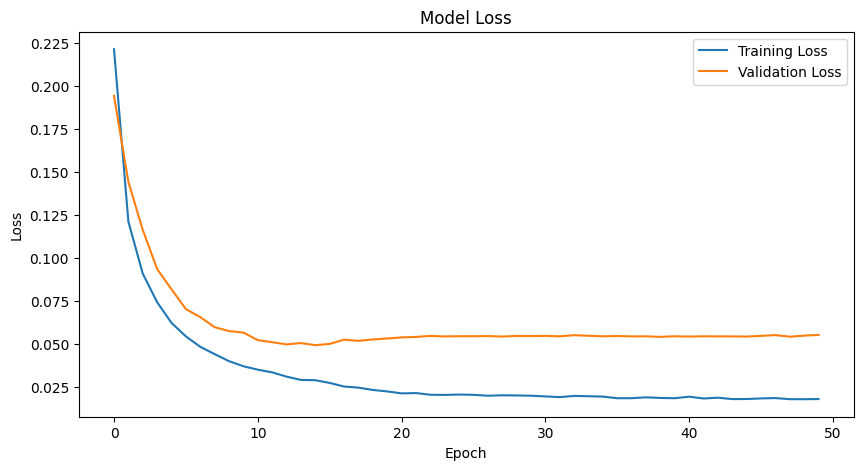

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
os.makedirs('data/models', exist_ok=True)
date = datetime.now().strftime('%Y-%m-%d')
path = 'data'
model_name = f"lstm_combined_model_{date}.keras"
model.save(f"data/models/{model_name}")
print(f"Saved LSTM model to models/{model_name}")

Saved LSTM model to models/lstm_combined_model_2025-04-07.keras


In [203]:
def predict_todays_closing_price_enriched(symbol):
    """
    Predict today's closing price for the given symbol using enriched price data that includes sentiment.
    
    Process:
    1. Load and update historical sentiment data.
    2. Scale the price and volume features (same as during training).
    3. Add one-hot encoding for symbols.
    4. Create the input sequence for the model.
    5. Predict the closing price.
    
    Returns:
        float or None: The predicted closing price for today, or None if not enough data.
    """
    # Load the scaler
    with open('data/scaler.pkl', 'rb') as f:
        scaler_info = pickle.load(f)
        SCALER = scaler_info['scaler']
        FEATURES_TO_SCALE = scaler_info['features_to_scale']
    
    # Load the trained model
    MODEL = load_model(f"data/models/lstm_combined_model_2025-03-29.keras")
    
    # Step 1: Load and update historical sentiment data
    df = bot.load_and_update_sentiment_data(SEQ_LENGTH)
    if df is None or df.empty:
        print("Failed to load sentiment data.")
        return None
    
    # Step 2: Scale numerical features using the same scaler from training
    df_scaled = df.copy()
    df_scaled[FEATURES_TO_SCALE] = SCALER.transform(df[FEATURES_TO_SCALE])
    
    # Step 3: Add one-hot encoding for symbols
    symbol_dummies = pd.get_dummies(df_scaled['symbol'], prefix='symbol').astype('float32')
    df_scaled = pd.concat([df_scaled, symbol_dummies], axis=1)
    
    # Get the full list of features for the model
    symbol_columns = [col for col in df_scaled.columns if col.startswith('symbol_')]
    all_features = FEATURES + symbol_columns
    
    # Step 4: Filter for the specific symbol and check data sufficiency
    symbol_df = df_scaled[df_scaled['symbol'] == symbol].sort_values(by="timestamp")
    if len(symbol_df) < SEQ_LENGTH:
        print(f"Not enough data for {symbol}. Need {SEQ_LENGTH} days, have {len(symbol_df)}.")
        return None
    
    # Create input sequence using the last SEQ_LENGTH rows
    input_seq = symbol_df.iloc[-SEQ_LENGTH:][all_features].values.astype('float32')
    input_seq = input_seq.reshape(1, SEQ_LENGTH, len(all_features))
    
    # Step 5: Make the prediction (scaled)
    predicted_scaled = MODEL.predict(input_seq, verbose=0)[0][0]
    
    # Step 6: Unscale the prediction
    # Get the index of 'close' in FEATURES_TO_SCALE
    close_idx = FEATURES_TO_SCALE.index('close')
    
    # Create a dummy array with zeros for all scalable features
    dummy = np.zeros((1, len(FEATURES_TO_SCALE)))
    # Place the scaled prediction in the position corresponding to 'close'
    dummy[0, close_idx] = predicted_scaled
    
    # Inverse transform to get the actual price
    unscaled_dummy = SCALER.inverse_transform(dummy)
    # Extract the unscaled closing price
    predicted_price = unscaled_dummy[0, close_idx]    
    print(f"Predicted closing price for {symbol} is ${predicted_price:.2f}")
    
    return predicted_price